# Introduction

In this notebook, we perform an uncertainty analysis of to understand the vulnerab ilities of four predefined policies and to evaluate their robustness across different scenarios (Robust Decision Making). RDM allows for a comparison of previously identified policy alternatives and for the discovery how various uncertainties affect the performance of each alternative.  It encompasses stress testing existing policies over a large ensemble of scenarios and identifying vulnerabilities in order to improve the policies (Bartholomew & Kwakkel, 2020).  This approach was used for four identified policies which were contenders in the policy debate for the EPA1361 class.

We conducted this analysis using two problem formulations because wanted to evaluate rival problem framings. PF1 outcomes are more aggregated, shows performance of indicators on a national level, may be prioritized by national governmental decision-makers. PF3 outcomes are more disaggregated, shows importance to local-level decision-makers and stakeholders.

## 0.0 Import libraries

In [47]:
from ema_workbench import (Model, RealParameter, ScalarOutcome, CategoricalParameter, IntegerParameter,
                           SequentialEvaluator, MultiprocessingEvaluator, ema_logging,
                           Policy, Constant, Scenario, Constraint, save_results, load_results)
from ema_workbench.analysis import parcoords, prim, feature_scoring
from ema_workbench.em_framework import optimization, get_SALib_problem
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.em_framework.evaluators import BaseEvaluator, SOBOL
from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress)
from problem_formulation import get_model_for_problem_formulation
ema_logging.log_to_stderr(ema_logging.INFO)

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from plotly.subplots import make_subplots
import plotly
import chart_studio.plotly as py
import chart_studio
import plotly.graph_objs as go
import plotly.express as px
from scipy.stats import mstats

## 1.0 Experimentation

### 1.1 Select problem formulation
For this analysis, we first selected Problem Formulation 1, which yields 3 outcomes:
* Expected Annual Damage
* Total Investment Costs
* Expected Number of Deaths

In [3]:
model_pf1, planning_steps = get_model_for_problem_formulation(1)

### 1.2 Specify policies

Specifying a clean slate in which the model's no-action-taken levers consists of the following:
* Early Warning System (EWS) to provide 3 days warning
* RfR: 0 to indicate no RFR implemented _(1 indicates RfR implemented)_
* DikeIncrease: 0 to indicate dikes are not heightened at all _(lever is specified in 1 decimeter increments)_

In [5]:
zero_policy = {'DaysToThreat': 3}
zero_policy.update({'DikeIncrease {}'.format(n): 0 for n in planning_steps})
zero_policy.update({'RfR {}'.format(n): 0 for n in planning_steps})

pol0 = {}
pol1 = {}
pol2 = {}
pol3 = {}

for key in model_pf1.levers:
    s1, s2 = key.name.split('_')
    pol0.update({key.name: zero_policy[s2]})
    pol1.update({key.name: zero_policy[s2]})
    pol2.update({key.name: zero_policy[s2]})
    pol3.update({key.name: zero_policy[s2]})

__Policy 1: RfR implemented in the short-term at all locations.__

In [6]:
pol0['0_RfR 0']=1
pol0['1_RfR 0']=1
pol0['2_RfR 0']=1
pol0['3_RfR 0']=1
pol0['4_RfR 0']=1

__Policy 2: RfR implemented upstream, and downstream dikes heightened by 5 dm in the short-term.__

In [7]:
pol1['0_RfR 0']=1
pol1['1_RfR 0']=1
pol1['A.3_DikeIncrease 0']=5
pol1['A.4_DikeIncrease 0']=5
pol1['A.5_DikeIncrease 0']=5

__Policy 3: RfR implemented at one downstream location, and an upstream dike heightened by 5 dm in the short-term.__

In [8]:
pol2['3_RfR 0']=1
pol2['A.1_DikeIncrease 0']=5
pol2['A.2_DikeIncrease 0']=5
pol2['A.3_DikeIncrease 0']=5

__Policy 4: Dikes heightened in the short-term at all locations.__

In [9]:
pol3['A.1_DikeIncrease 0']=5
pol3['A.2_DikeIncrease 0']=5
pol3['A.3_DikeIncrease 0']=5
pol3['A.4_DikeIncrease 0']=5
pol3['A.5_DikeIncrease 0']=5

In [10]:
policy0 = [Policy('All RfR', **pol0), Policy('Upstream RfR downstream dikes', **pol1),
           Policy('Upstream dikes Downstream RfR', **pol2), Policy('All Dikes', **pol3)]

In [ ]:
# with MultiprocessingEvaluator(model_pf1) as evaluator:
#     results_pf1 = evaluator.perform_experiments(scenarios=200, policies=policy0,
#                                                 uncertainty_sampling = SOBOL)

# save_results(results, 'results/robust-decision-making/rdm_pf1_200s_SOBOL.tar.gz')

We also performed this analysis using Problem Formulation 3, which yields 12 outcomes:
* Total Costs at each dike ring location
* Expected Number of Deaths at each dike ring location
* RfR Total Costs
* Expected Evacuation Costs

In [11]:
model_pf3, planning_steps = get_model_for_problem_formulation(3)

In [13]:
# with MultiprocessingEvaluator(model_pf3) as evaluator:
#     results_pf3 = evaluator.perform_experiments(scenarios=200, policies=policy0,
#                                                 uncertainty_sampling = SOBOL)

# save_results(results, 'results/robust-decision-making/rdm_pf3_200s_SOBOL.tar.gz')

## 2.0 Analysis of Results

With the results, we conducted a global sensitivity analysis to account for non-linearities and parameter interactions within the model (Jaxa-Rozen & Kwakkel, 2018). Sensitivity analysis is also useful for understanding the relative importance of model input parameters (Saltelli et al., 2019).

Sobol Global Sensitivity Analysis (GSA) provides first-order and total indices that account for the sensitivity in the outcomes due to individual parameters and higher order interactions. Variance based GSA is also argued to be most prominently used in literature (Jaxa-Rozen & Kwakkel, 2018). This was used to understand the vulnerabilities of the four identified policies.

### 2.1 Overview of results

In [16]:
experiments_1, outcomes_1 = load_results("results/robust-decision-making/rdm_pf1_200s_SOBOL.tar.gz")

[MainProcess/INFO] results loaded succesfully from C:\Users\jryap\Desktop\Final Results\results\robust-decision-making\rdm_pf1_200s_SOBOL.tar.gz


In [17]:
experiments_3, outcomes_3 = load_results("results/robust-decision-making/rdm_pf3_200s_SOBOL.tar.gz")

[MainProcess/INFO] results loaded succesfully from C:\Users\jryap\Desktop\Final Results\results\robust-decision-making\rdm_pf3_200s_SOBOL.tar.gz


In [18]:
# pf1
policies_1 = experiments_1['policy']

data = pd.DataFrame.from_dict(outcomes_1)
data['policy'] = policies_1

uncertainties_1 = experiments_1.iloc[:, :16]
uncertainties_outcomes_1 = pd.concat([uncertainties_1, data], axis=1)

# pf3
policies_3 = experiments_3['policy']

data_3 = pd.DataFrame.from_dict(outcomes_3)
data_3['policy'] = policies_3

uncertainties_3 = experiments_3.iloc[:, :16]
uncertainties_outcomes_3 = pd.concat([uncertainties_3, data_3], axis=1)

In [20]:
uncertainties_outcomes_1 = uncertainties_outcomes_1[['Total Investment Costs',
                                                     'Expected Number of Deaths',
                                                     'Expected Annual Damage', 'policy']]
uncertainties_outcomes_3 = uncertainties_outcomes_3[['A.1 Total Costs', 'A.1_Expected Number of Deaths',
                                                     'A.4 Total Costs', 'A.4_Expected Number of Deaths',
                                                     'Expected Evacuation Costs', 'policy']]

In [21]:
uncertainties_outcomes_1['Problem Formulation'] = 'Pf1'
uncertainties_outcomes_3['Problem Formulation'] = 'Pf3'

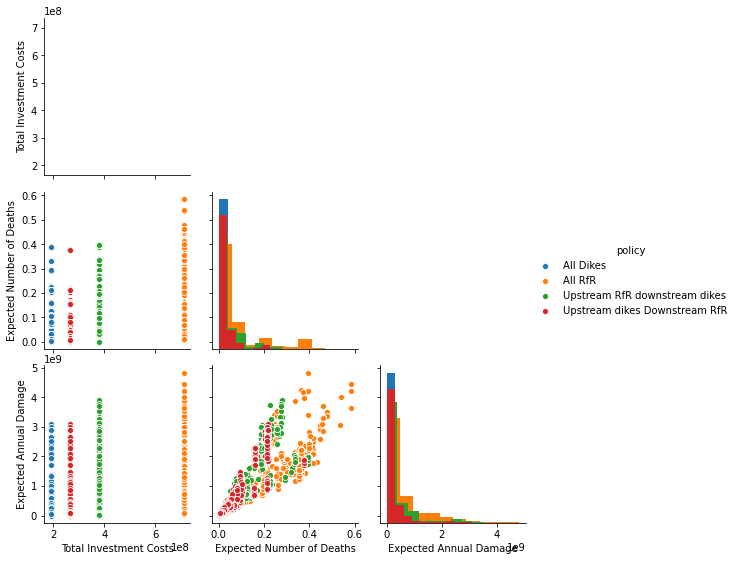

In [25]:
g = sns.pairplot(uncertainties_outcomes_1, diag_kind='hist', hue = 'policy')
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
plt.show()
g.savefig('figures/rdm_pf1.png', dpi = 300)

In [28]:
fig = px.scatter(uncertainties_outcomes_3, 
           x = 'A.1 Total Costs', y = 'A.1_Expected Number of Deaths', color='policy', 
                 facet_col = 'policy', width = 1200, height = 600, color_discrete_sequence=px.colors.qualitative.Pastel)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
# fig.update_xaxes(matches=None)
fig.update_layout(template='plotly_white')
fig.show()
fig.write_image("figures/rdm_pf3_A1_policy.png", scale = 3)

In [29]:
fig = px.scatter(uncertainties_outcomes_3, 
           x = 'A.4 Total Costs', y = 'A.4_Expected Number of Deaths', color='policy', facet_col = 'policy',
                width = 1200, height = 600, color_discrete_sequence=px.colors.qualitative.Pastel)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
# fig.update_xaxes(matches=None)
fig.update_layout(template='plotly_white')
fig.show()
fig.write_image("figures/rdm_pf3_A4_policy.png", scale = 3)

In [ ]:
uncertainties_outcomes_3_costs = pd.melt(uncertainties_outcomes_3,
                                         value_vars = ['A.1 Total Costs', 'A.4 Total Costs'],
                                         id_vars = 'policy')
uncertainties_outcomes_3_costs.columns = ['Policy', 'Outcome','Total Costs']
uncertainties_outcomes_3_costs.columns = ['Policy', 'Outcome','Total Costs']

uncertainties_outcomes_3_deaths = pd.melt(uncertainties_outcomes_3,
                                          value_vars = ['A.1_Expected Number of Deaths',
                                                        'A.4_Expected Number of Deaths'], 
                                          id_vars = 'policy')
uncertainties_outcomes_3_deaths.columns = ['Policy', 'Outcome','Expected Number of Deaths']

uncertainties_outcomes_3_evac = pd.melt(uncertainties_outcomes_3,
                                        value_vars = ['Expected Evacuation Costs'], 
                                        id_vars = 'policy')
uncertainties_outcomes_3_evac.columns = ['Policy', 'Outcome','Expected Evacuation Costs']

In [ ]:
fig = px.box(uncertainties_outcomes_3_evac, 
           x = 'Policy', y = 'Expected Evacuation Costs', color="Policy",
             template='plotly_white',
             notched=False, # used notched shape
#              points='all',
             color_discrete_sequence=px.colors.qualitative.Pastel,
             title="Pf3: Evacuation Costs Under Each Policy",
            width = 1200, height = 600)
                                    
fig.update_layout(showlegend=False)
fig.update_traces(boxpoints='all', jitter=0.9, marker=dict(size=2, opacity=0.5), pointpos=0)
# fig.update_yaxes(range = [0, 2e9])
#py.iplot(fig, filename = 'CT_box', auto_open=True)
fig.show()
fig.write_image("figures/rdm_pf3_evac_costs_box.png", scale = 3)

In [ ]:
fig = px.box(uncertainties_outcomes_3_costs, 
           x = 'Policy', y = 'Total Costs', color="Outcome",
             template='plotly_white',
             notched=False, # used notched shape
#              points='all',
             color_discrete_sequence=px.colors.qualitative.Pastel,
             title="Pf3: Total Costs Under Each Policy",
            width = 1200, height = 600)
                                    
fig.update_layout(showlegend=True)
fig.update_traces(boxpoints='all', jitter=0.9, marker=dict(size=2, opacity=0.5), pointpos=0)
fig.update_yaxes(range = [0, 2e9])
#py.iplot(fig, filename = 'CT_box', auto_open=True)
fig.show()
fig.write_image("figures/rdm_pf3_costs_box.png", scale = 3)

In [ ]:
fig = px.box(uncertainties_outcomes_3_deaths, 
           x = 'Policy', y = 'Expected Number of Deaths', color="Outcome",
             template='plotly_white',
             notched=False, # used notched shape
#              points='all',
             color_discrete_sequence=px.colors.qualitative.Pastel,
             title="Pf3: Expected Number of Deaths Under Each Policy",
            width = 1200, height = 600)
                                    
fig.update_layout(showlegend=True, legend_orientation="h")
fig.update_traces(boxpoints='all', jitter=0.9, marker=dict(size=2, opacity=0.5), pointpos=0)
# fig.update_yaxes(range = [0, 2e9])
#py.iplot(fig, filename = 'CT_box', auto_open=True)
fig.show()
fig.write_image("figures/rdm_pf3_deaths_box.png", scale = 3)

In [ ]:
fig = px.box(uncertainties_outcomes_1, 
           x = 'policy', y = 'Expected Number of Deaths', color="policy",
             template='plotly_white',
             notched=False, # used notched shape
#              points='all',
             color_discrete_sequence=px.colors.qualitative.Pastel,
             title="Pf1: Expected Number of Deaths Under Each Policy",
            width = 1200, height = 600)
                                    
fig.update_layout(showlegend=False)
fig.update_traces(boxpoints='all', jitter=0.9, marker=dict(size=2, opacity=0.5), pointpos=0)
#py.iplot(fig, filename = 'CT_box', auto_open=True)
fig.show()
fig.write_image("figures/rdm_pf1_deaths_box.png", scale = 3)

In [ ]:
fig = px.box(uncertainties_outcomes_1, 
           x = 'policy', y = 'Expected Annual Damage', color="policy",
             template='plotly_white',
             notched=False, # used notched shape
#              points='all',
             color_discrete_sequence=px.colors.qualitative.Pastel,
             title="Pf1: Expected Annual Damage Under Each Policy",
            width = 1200, height = 600)
                                    
fig.update_layout(showlegend=False)
fig.update_traces(boxpoints='all', jitter=0.9, marker=dict(size=2, opacity=0.5), pointpos=0)
#py.iplot(fig, filename = 'CT_box', auto_open=True)
fig.show()
fig.write_image("figures/rdm_pf1_damage_box.png", scale = 3)

In [30]:
fig = px.bar(uncertainties_outcomes_1.groupby('policy').mean().reset_index().sort_values('Total Investment Costs', ascending = False), 
           x = 'policy', y = 'Total Investment Costs', color="policy",
             template='plotly_white',
#              notched=False, # used notched shape
#              points='all',
             color_discrete_sequence=px.colors.qualitative.Pastel,
             title="Pf1: Total Investment Costs Under Each Policy",
            width = 1200, height = 600) # add day column to hover data
                                    
fig.update_layout(showlegend=False)
# fig.update_traces(boxpoints='all', jitter=0.9, marker=dict(size=2, opacity=0.5), pointpos=0)
#py.iplot(fig, filename = 'CT_box', auto_open=True)
fig.show()
fig.write_image("figures/rdm_pf1_costs_bar.png", scale = 3)

### 2.2 Sensitivity Analysis: SOBOL

In [33]:
from SALib.analyze.sobol import analyze
from ema_workbench.em_framework.evaluators import SOBOL
from ema_workbench.em_framework import get_SALib_problem

# pf1
problem1 = get_SALib_problem(model_pf1.uncertainties)

sobol_results = {}
indices_dfs_pf1 = {}
for outcome in outcomes_1.keys():
    for policy in experiments_1.policy.unique():
        logical = experiments_1.policy == policy
        y1 = outcomes_1[outcome][logical]
        indices = analyze(problem1, y1)
        sobol_results[policy] = indices
        indices_dfs_pf1[outcome] = pd.concat([indices.to_df()[0],indices.to_df()[1]], axis = 1)

# pf3
problem3 = get_SALib_problem(model_pf3.uncertainties)

sobol_results = {}
indices_dfs_pf3 = {}
for outcome in outcomes_3.keys():
    for policy in experiments_3.policy.unique():
        logical = experiments_3.policy == policy
        y3 = outcomes_3[outcome][logical]
        indices = analyze(problem3, y3)
        sobol_results[policy] = indices
        indices_dfs_pf3[outcome] = pd.concat([indices.to_df()[0],indices.to_df()[1]], axis = 1)

C:\Users\jryap\Anaconda3\envs\primary\lib\site-packages\SALib\analyze\sobol.py:93: RuntimeWarning:

invalid value encountered in true_divide



In [34]:
indices_dfs_pf1['Expected Annual Damage']['Outcome'] = 'Expected Annual Damage'
indices_dfs_pf1['Total Investment Costs']['Outcome'] = 'Total Investment Costs'
indices_dfs_pf1['Expected Number of Deaths']['Outcome'] = 'Expected Number of Deaths'

indices_dfs_pf1_all = pd.concat([indices_dfs_pf1['Expected Annual Damage'], indices_dfs_pf1['Total Investment Costs'],
                                indices_dfs_pf1['Expected Number of Deaths']], axis = 0)

In [35]:
indices_dfs_pf3['A.1 Total Costs']['Outcome'] = 'A.1 Total Costs'
indices_dfs_pf3['A.1_Expected Number of Deaths']['Outcome'] = 'A.1_Expected Number of Deaths'
indices_dfs_pf3['A.2 Total Costs']['Outcome'] = 'A.2 Total Costs'
indices_dfs_pf3['A.2_Expected Number of Deaths']['Outcome'] = 'A.2_Expected Number of Deaths'
indices_dfs_pf3['A.3 Total Costs']['Outcome'] = 'A.3 Total Costs'
indices_dfs_pf3['A.3_Expected Number of Deaths']['Outcome'] = 'A.3_Expected Number of Deaths'
indices_dfs_pf3['A.4 Total Costs']['Outcome'] = 'A.4 Total Costs'
indices_dfs_pf3['A.4_Expected Number of Deaths']['Outcome'] = 'A.4_Expected Number of Deaths'
indices_dfs_pf3['A.5 Total Costs']['Outcome'] = 'A.5 Total Costs'
indices_dfs_pf3['A.5_Expected Number of Deaths']['Outcome'] = 'A.5_Expected Number of Deaths'
indices_dfs_pf3['Expected Evacuation Costs']['Outcome'] = 'Expected Evacuation Costs'
indices_dfs_pf3['RfR Total Costs']['Outcome'] = 'RfR Total Costs'

indices_dfs_pf3_all = pd.concat(list(indices_dfs_pf3.values()), axis = 0)

In [36]:
fig = px.bar(indices_dfs_pf1_all.reset_index().sort_values('ST', ascending=False).iloc[:12,:], x = 'index', y="ST", color="index",
                 error_y="ST_conf", facet_row = 'Outcome', height = 800)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_yaxes(matches=None)
fig.update_layout(showlegend=False)

fig['layout']['yaxis']['title']['text']=''
fig['layout']['yaxis1']['title']['text']=''
fig['layout']['yaxis3']['title']['text']=''

fig.write_image("figures/SOBOL_pf1_ST_error.png", scale = 3)
fig.show()

In [37]:
fig = px.bar(indices_dfs_pf1_all.reset_index().sort_values('ST', ascending=False).iloc[:10,:], x = 'index', y="S1", color="index",
                 error_y="S1_conf", facet_row = 'Outcome', height = 800)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_yaxes(matches=None)
fig.update_layout(showlegend=False)

fig['layout']['yaxis']['title']['text']=''
fig['layout']['yaxis1']['title']['text']=''
fig['layout']['yaxis3']['title']['text']=''

fig.write_image("figures/SOBOL_pf1_S1_error.png", scale = 3)
fig.show()

In [38]:
import plotly.express as px

fig = px.bar(indices_dfs_pf3_all.reset_index(), x = 'index', y="ST", color="index",
                 error_y="ST_conf", facet_row = 'Outcome', height = 1500, width = 800)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_yaxes(matches=None)
fig.update_layout(showlegend=False, font = {'size': 7})

fig['layout']['yaxis']['title']['text']=''
fig['layout']['yaxis1']['title']['text']=''
fig['layout']['yaxis2']['title']['text']=''
fig['layout']['yaxis3']['title']['text']=''
fig['layout']['yaxis4']['title']['text']=''
fig['layout']['yaxis5']['title']['text']=''
fig['layout']['yaxis6']['title']['text']=''
fig['layout']['yaxis7']['title']['text']=''
fig['layout']['yaxis8']['title']['text']=''
fig['layout']['yaxis9']['title']['text']=''
fig['layout']['yaxis10']['title']['text']=''
fig['layout']['yaxis11']['title']['text']=''
fig['layout']['yaxis12']['title']['text']=''

fig.write_image("figures/SOBOL_pf3_ST_error.png", scale = 3)
fig.show()

In [39]:
fig = px.bar(indices_dfs_pf3_all.reset_index(), x = 'index', y="S1", color="index",
                 error_y="S1_conf", facet_row = 'Outcome', height = 1500, width = 800)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_yaxes(matches=None)
fig.update_layout(showlegend=False, font = {'size': 7})

fig['layout']['yaxis']['title']['text']=''
fig['layout']['yaxis1']['title']['text']=''
fig['layout']['yaxis2']['title']['text']=''
fig['layout']['yaxis3']['title']['text']=''
fig['layout']['yaxis4']['title']['text']=''
fig['layout']['yaxis5']['title']['text']=''
fig['layout']['yaxis6']['title']['text']=''
fig['layout']['yaxis7']['title']['text']=''
fig['layout']['yaxis8']['title']['text']=''
fig['layout']['yaxis9']['title']['text']=''
fig['layout']['yaxis10']['title']['text']=''
fig['layout']['yaxis11']['title']['text']=''
fig['layout']['yaxis12']['title']['text']=''

fig.write_image("figures/SOBOL_pf3_S1_error.png", scale = 3)
fig.show()

In [40]:
heat = go.Heatmap(z=indices_dfs_pf1['Expected Annual Damage'], x=indices_dfs_pf1['Expected Annual Damage'].drop('Outcome', axis = 1).columns.tolist(), 
                  y=indices_dfs_pf1['Expected Annual Damage'].reset_index()['index'], xgap=10, ygap=10,
                  colorscale = plotly.colors.sequential.Reds)

plot_data = [heat]

# plotly.offline.plot(plot_data, filename='reports/graphics/access_metrics/heatmap_50_cities.html')

layout = go.Layout(title = "",
                   width=650, height=600,
                   xaxis_showgrid=False,
                   yaxis_showgrid=False,
                   template = "plotly_white", )#yaxis_autorange='reversed')
   
fig=go.Figure(data=[heat], layout=layout) 

fig.write_image("figures/SOBOL_pf1_damage.png", scale = 3)
fig.show()

In [41]:
heat = go.Heatmap(z=indices_dfs_pf1['Total Investment Costs'], x=indices_dfs_pf1['Total Investment Costs'].drop('Outcome', axis = 1).columns.tolist(), 
                  y=indices_dfs_pf1['Total Investment Costs'].reset_index()['index'], xgap=10, ygap=10,
                  colorscale = plotly.colors.sequential.Reds)

plot_data = [heat]

# plotly.offline.plot(plot_data, filename='reports/graphics/access_metrics/heatmap_50_cities.html')

layout = go.Layout(title = "",
                   width=650, height=600,
                   xaxis_showgrid=False,
                   yaxis_showgrid=False,
                   template = "plotly_white", )#yaxis_autorange='reversed')
   
fig=go.Figure(data=[heat], layout=layout) 

fig.write_image("figures/SOBOL_pf1_costs.png", scale = 3)
fig.show()

In [42]:
heat = go.Heatmap(z=indices_dfs_pf1['Expected Number of Deaths'], x=indices_dfs_pf1['Expected Number of Deaths'].drop('Outcome', axis = 1).columns.tolist(), 
                  y=indices_dfs_pf1['Expected Number of Deaths'].reset_index()['index'], xgap=10, ygap=10,
                  colorscale = plotly.colors.sequential.Reds)

plot_data = [heat]

# plotly.offline.plot(plot_data, filename='reports/graphics/access_metrics/heatmap_50_cities.html')

layout = go.Layout(title = "",
                   width=650, height=600,
                   xaxis_showgrid=False,
                   yaxis_showgrid=False,
                   template = "plotly_white", )#yaxis_autorange='reversed')
   
fig=go.Figure(data=[heat], layout=layout) 

fig.write_image("figures/SOBOL_pf1_deaths.png", scale = 3)
fig.show()

In [43]:
for df in indices_dfs_pf3:
   
    heat = go.Heatmap(z=indices_dfs_pf3[df], x=indices_dfs_pf3[df].drop('Outcome', axis = 1).columns.tolist(), 
                  y=indices_dfs_pf3[df].reset_index()['index'], xgap=10, ygap=10,
                  colorscale = plotly.colors.sequential.Reds)

    plot_data = [heat]

    # plotly.offline.plot(plot_data, filename='reports/graphics/access_metrics/heatmap_50_cities.html')

    layout = go.Layout(title = str(df),
                       width=650, height=600,
                       xaxis_showgrid=False,
                       yaxis_showgrid=False,
                       template = "plotly_white", )#yaxis_autorange='reversed')

    fig=go.Figure(data=[heat], layout=layout) 
    
    fig.show()
    fig.write_image(f"figures/SOBOL_pf3_{df}.png", scale = 3)

### 2.3 Feature Scoring

In [48]:
cleaned_experiments_1 = experiments_1.drop(columns=[l.name for l in model_pf1.levers])

for policy in experiments_1.policy.unique():
    logical = experiments_1.policy == policy
    subset_results = {k:v[logical] for k,v in outcomes_1.items()}
    scores = feature_scoring.get_feature_scores_all(cleaned_experiments_1[logical],
                                                   subset_results)
    heat = go.Heatmap(z=scores, x=scores.columns.tolist(), 
                  y=scores.reset_index()['index'], xgap=10, ygap=10,
                  colorscale = plotly.colors.sequential.Reds)

    plot_data = [heat]

    # plotly.offline.plot(plot_data, filename='reports/graphics/access_metrics/heatmap_50_cities.html')

    layout = go.Layout(title = str(policy),
                       width=650, height=600,
                       xaxis_showgrid=False,
                       yaxis_showgrid=False,
                       template = "plotly_white", )#yaxis_autorange='reversed')

    fig=go.Figure(data=[heat], layout=layout) 
    
    fig.show()
    fig.write_image(f"figures/FS_pf1_{policy}.png", scale = 3)

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


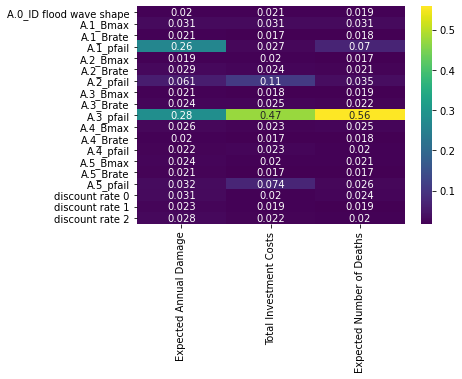

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


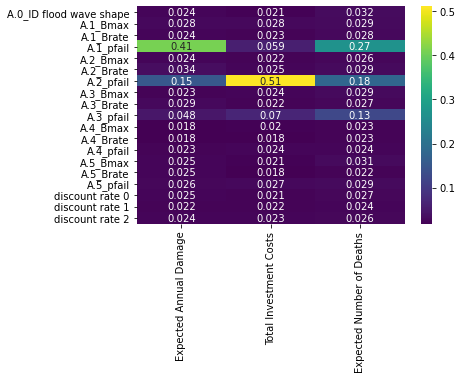

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


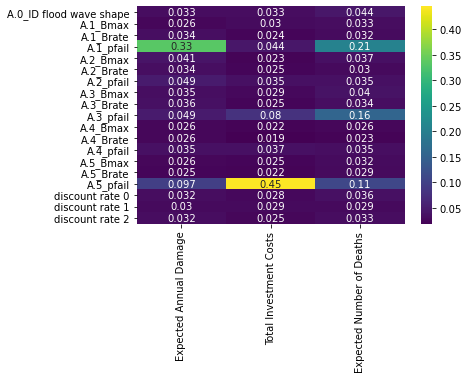

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


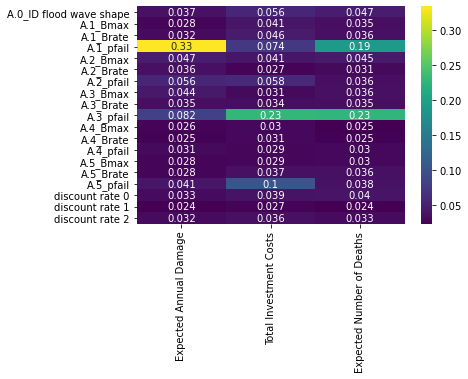

In [49]:
cleaned_experiments_1 = experiments_1.drop(columns=[l.name for l in model_pf1.levers])

for policy in experiments_1.policy.unique():
    logical = experiments_1.policy == policy
    subset_results = {k:v[logical] for k,v in outcomes_1.items()}
    scores = feature_scoring.get_feature_scores_all(cleaned_experiments_1[logical],
                                                   subset_results)
    sns.heatmap(scores, annot=True, cmap='viridis')
    plt.show()

In [50]:
cleaned_experiments_3 = experiments_3.drop(columns=[l.name for l in model_pf3.levers])

for policy in experiments_3.policy.unique():
    logical = experiments_3.policy == policy
    subset_results = {k:v[logical] for k,v in outcomes_3.items()}
    scores = feature_scoring.get_feature_scores_all(cleaned_experiments_3[logical],
                                                   subset_results)
    heat = go.Heatmap(z=scores, x=scores.columns.tolist(), 
                  y=scores.reset_index()['index'], xgap=10, ygap=10,
                  colorscale = plotly.colors.sequential.Reds)

    plot_data = [heat]

    # plotly.offline.plot(plot_data, filename='reports/graphics/access_metrics/heatmap_50_cities.html')

    layout = go.Layout(title = str(policy),
                       width=650, height=600,
                       xaxis_showgrid=False,
                       yaxis_showgrid=False,
                       template = "plotly_white", )#yaxis_autorange='reversed')

    fig=go.Figure(data=[heat], layout=layout) 
    
    fig.show()
    fig.write_image(f"figures/FS_pf3_{policy}.png", scale = 3)

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because on

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because on

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because on

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because on

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because on

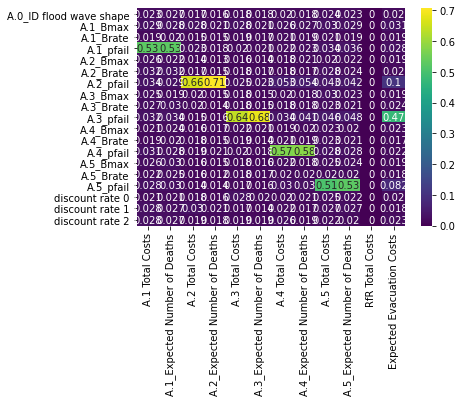

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because on

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because on

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because on

In [51]:
cleaned_experiments_3 = experiments_3.drop(columns=[l.name for l in model_pf3.levers])

for policy in experiments_3.policy.unique():
    logical = experiments_3.policy == policy
    subset_results = {k:v[logical] for k,v in outcomes_3.items()}
    scores = feature_scoring.get_feature_scores_all(cleaned_experiments_3[logical],
                                                   subset_results)
    sns.heatmap(scores, annot=True, cmap='viridis')
    plt.show()